In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd

In [2]:
SELECTED_DATA = os.path.join('data', 'selected_dataset')
ORIGINAL_DATA = os.path.join('data', 'cleaned_dataset')
PROCESSED_DATASET = os.path.join('data', 'processed_dataset')
SAMPLE_IMAGE = 'data/selected_dataset/normal/DSC03990_5.JPG'

In [3]:
base_model = ResNet50(weights='imagenet', include_top=False)

In [ ]:
model.summary()

In [ ]:
model.layers[-4].get_weights()

## Sample Image

In [23]:
from PIL import Image
import matplotlib.pyplot as plt
from random import randint

In [18]:
def show_image_and_feature_maps(image_path):
    loaded_image = load_img(image_path, target_size=(224,224))
    image = img_to_array(loaded_image)
    image = preprocess_input(image)

    avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=avg)
    feature_maps = base_model.predict(np.array([image]))

    # show the images
    plt.imshow(loaded_image.rotate(-90))

    # plot first 20 filters
    n_filters = 20
    # specify subplot and turn of axis
    fig, ax = plt.subplots(4, 5)

    # show the first 20 feature map
    for i in range(n_filters):
        # specify subplot and turn of axis
        ax[i//5, i%5].imshow(feature_maps[0, :, :, i], cmap='gray')
        ax[i//5, i%5].axis('off')

    return model.predict(np.array([image]))

In [28]:
def show_random_image(label):
    class_folder = os.path.join(SELECTED_DATA, label)
    list_files = os.listdir(class_folder)
    random_idx = randint(0, len(list_files))
    file_path = os.path.join(class_folder, list_files[random_idx])
    print(file_path)
    return show_image_and_feature_maps(file_path)

data\selected_dataset\infected\DSC04121_6.JPG
1/1 [==============================] - 2s 2s/step


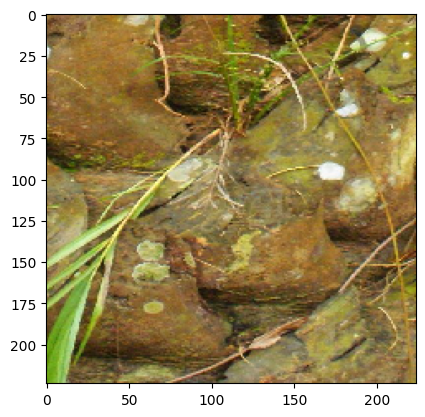

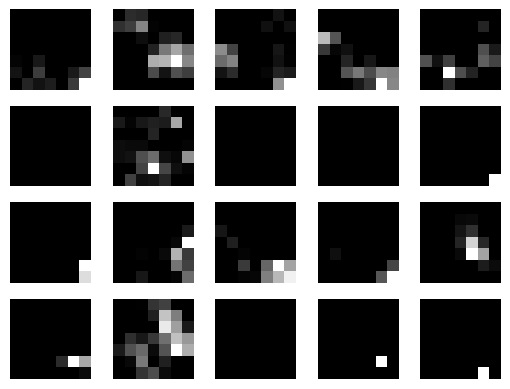

In [33]:
infected_sample = show_random_image('infected')

In [34]:
infected_sample

array([[0.594866  , 0.98545885, 0.79620767, ..., 0.08128063, 0.50376993,
        0.00265578]], dtype=float32)

data\selected_dataset\normal\DSC04061_7.JPG
1/1 [==============================] - 2s 2s/step


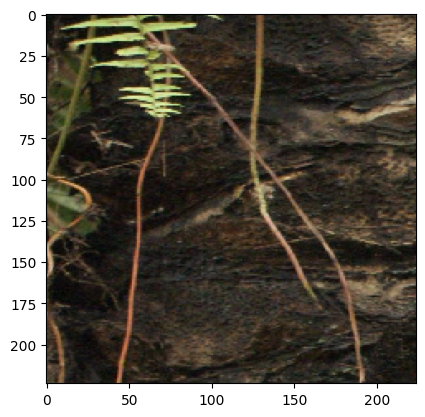

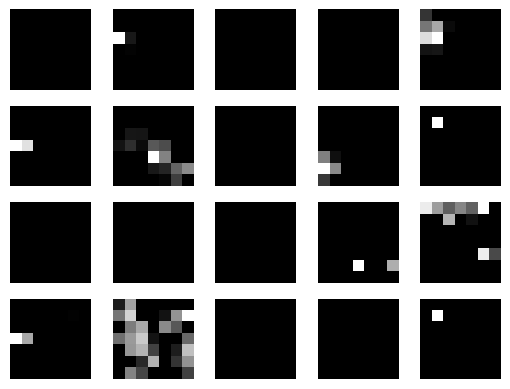

In [38]:
normal_sample = show_random_image('normal')

In [39]:
normal_sample

array([[0.        , 0.04382531, 0.        , ..., 0.15336636, 0.0036156 ,
        0.00652949]], dtype=float32)

## Batch Feature Extraction

In [12]:
def extract_and_export(image_path, export_name):
    batch_images = []
    label = []
    file_names = []
    class_map = {'normal': 0, 'infected': 1}
    for image_class in os.listdir(image_path):
        class_path = os.path.join(image_path, image_class)
        for image_file in os.listdir(class_path):
    #         print(os.path.join(class_path, image_file))
            image = load_img(os.path.join(class_path, image_file), target_size=(224,224))
            image = img_to_array(image)
            image = preprocess_input(image)
            batch_images.append(image)
            label.append(class_map[image_class])
            file_names.append(image_file)
            
    batch_images = np.array(batch_images)
    features = model.predict(batch_images)
    # features = features.reshape((2000,-1))

    features_df = pd.DataFrame(features,
                               columns=[f'resnet_{x+1}' for x in range(features.shape[-1])])
    features_df['is_infected'] = label
    features_df.insert(0, 'file_name', file_names)
    # features_df.to_csv(os.path.join('data', export_name+'.csv'), index=False)
    features_df.to_parquet(os.path.join('data', export_name+'.parquet'), index=False)
    # features_df.to_excel(os.path.join('data', 'excel', export_name+'.xlsx'), index=False)
    return features_df

In [13]:
orig_df = extract_and_export(SELECTED_DATA, 'resnet50_img_feature_224_globalavgpool')

63/63 [==============================] - 114s 2s/step


In [14]:
orig_df.shape

(2000, 2050)